# Project 4, APS1070 Summer 2020
#### **Linear Regression -  20 points**
**Deadline: Aug 2, 23:00**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Please fill out the following:


*   Your **name**: Matthew McFee
*   Your **student number**: 1005449631



## Part 1 - Getting Started [1 mark]

In this project, we are designing a controller to manage the ailerons of an F16 Aircraft! 
![Ailerons](https://raw.githubusercontent.com/aps1070-2019/datasets/master/img/airplane.gif) [Ref](https://www.grc.nasa.gov/www/k-12/BGA/Mike/airplane_parts_act.htm) 


The features describe the airplane's status, and the target is to predict the `Goal` column, which is a command that our controller should issue.

In [ ]:
import pandas as pd 

df=pd.read_csv("https://raw.githubusercontent.com/aps1070-2019/datasets/master/F16L.csv" , skipinitialspace=True)

In [ ]:
df.head(10)

df.shape

(13750, 41)

1. Split the dataset into training/validation sets (80% training, 20% validation). Note: While splitting use the value of **random state=41**.
2. Standardize the data using StandardScaler from sklearn.

In [ ]:
# Import the necessary functions
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select the appropriate columns for X and y
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=41)

# Scale the data appropriately 

sc = StandardScaler()

# Fit to the training data to prevent leakage of test data information into
# training 

sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

train_bias = np.ones(X_train.shape[0])
test_bias = np.ones(X_test.shape[0])

X_train_an = np.concatenate((X_train, train_bias.reshape(-1,1)), 1)
X_test_an = np.concatenate((X_test, test_bias.reshape(-1,1)), 1)

## Part 2 - Direct Solution [1 mark]

Implement the direct solution for linear regression on the dataset above (without regularizer).
Report training and validation error.

In [ ]:
# Import RMSE function from sklearn
from sklearn.metrics import mean_squared_error
import numpy as np

# RMSE function as seen in the tutorial
def rmse(y_pred, y):
    return np.sqrt(mean_squared_error(y_pred, y))

# This is the analytical solution for the weights

W_an = np.dot(np.linalg.inv(np.dot(X_train_an.T, X_train_an)),
              np.dot(X_train_an.T, y_train))

# Predicted values for training set and error

y_pred_train = np.dot(X_train_an, W_an)

train_error = rmse(y_pred_train, y_train)

# Predicted values for test set and error

y_pred_test = np.dot(X_test_an, W_an)

test_error = rmse(y_pred_test, y_test)

# Print the values 

print("The RMSE for the training set is: ", train_error)
print("The RMSE for the test set is: ", test_error)

The RMSE for the training set is:  0.00017967071725802483
The RMSE for the test set is:  0.00017545534760897958


In [ ]:
W_an

array([ 7.61565118e-05,  6.49208109e-06, -1.30444167e-04,  4.19623763e-06,
        9.49624328e-05, -8.17931025e-05,  2.39295793e-04, -3.31928641e-05,
        3.55274449e-05,  6.41741252e-09,  7.30150860e-05,  8.85374632e-03,
       -8.93425356e-03, -1.12290820e-03,  1.02159610e-03, -6.27753683e-03,
        6.33855577e-03,  1.60680910e-03, -1.66784232e-03, -9.57871920e-05,
        1.04625396e-04, -3.92750440e-04,  3.46634230e-04,  1.54174852e-03,
       -1.17141329e-05, -1.26561527e-05, -1.74808104e-06,  4.27169872e-06,
       -3.02451292e-06,  2.93500556e-05, -8.71274784e-06,  3.79723746e-06,
       -9.67677684e-06,  1.51980793e-06, -3.28392544e-06, -3.46585583e-07,
       -3.54531358e-06, -4.70715058e-06, -2.54515661e-05, -1.65420607e-03,
       -8.71172727e-04])

## Part 3 - Gradient Descent (GD) [2 marks]

1. Implement gradient descent (full-batch) for linear regression using a fixed learning rate of $\alpha= 1e-2$. You should compute the gradients yourself! First try to implement it without looking at other resources, but if you need a hint take a look [here](https://towardsdatascience.com/gradient-descent-explanation-implementation-c74005ff7dd1) and [here](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html).

2. Run the gradient descent for a fixed number of epochs (based on convergence) and verify that the results are closely approximate the direct solution.

In [ ]:
# Gradient descent
import copy
from sklearn.utils import shuffle

def calculate_values(W, X):
  y_pred = np.dot(X, W[1:]) + W[0]
  # y_pred = np.dot(X, W)
  return y_pred 

def calculate_error(y_pred, y_true):
  return (y_true - y_pred)

def update_weights(X, error, W, learning_rate):

  # Ask about dropping the 2 
  loss_1 = -2*(learning_rate/X.shape[0])*(np.dot(error, X))
  #loss_1 = -1*(learning_rate)*(np.dot(error, X))
  loss_2 = -2*learning_rate*error.sum()/X.shape[0]
  #loss_2 = -1*(learning_rate)*error.sum()
  W[1:] = W[1:] - loss_1
  W[0] = W[0] - loss_2
  return W

def gradient_descent(X_train, y_train, learning_rate, n_iter, tol):

  # Initialize, safe to use zeros based on the analytical solution 
  W = np.zeros(41)

  # List to store the RMSE
  # rmse_values = []

  # Initialize rmse values to avoid call before defined error
  rmse_value = 0
  rmse_old = 0

  for i in range(1, n_iter+1):

    # Store the old rmse value from last iteration
    rmse_old = copy.deepcopy(rmse_value)

    y_pred = calculate_values(W, X_train)
    error = calculate_error(y_pred, y_train)
    W = update_weights(X_train, error, W, learning_rate)
    rmse_value = rmse(y_pred, y_train)

    # Break early when the target tol is reached
    if abs(rmse_value - rmse_old) <= tol:
      break
    else:
      continue

  return W, i, rmse_value

W, i, rmse_value = gradient_descent(X_train, y_train, 0.01, 10000, 1e-10)

In [ ]:
y_train_pred = np.dot(X_train, W[1:]) + W[0]
y_test_pred = np.dot(X_test, W[1:]) + W[0]

print(rmse(y_train_pred, y_train))
print(rmse(y_test_pred, y_test))
print(i)

# Check the intercepts (they match)
print(W[0])
print(W_an[-1])

0.00017413143241967502
0.00017207438668957696
650
-0.0008711710012223278
-0.0008711727272727212


In [ ]:
W_an

array([ 7.61565118e-05,  6.49208109e-06, -1.30444167e-04,  4.19623763e-06,
        9.49624328e-05, -8.17931025e-05,  2.39295793e-04, -3.31928641e-05,
        3.55274449e-05,  6.41741252e-09,  7.30150860e-05,  8.85374632e-03,
       -8.93425356e-03, -1.12290820e-03,  1.02159610e-03, -6.27753683e-03,
        6.33855577e-03,  1.60680910e-03, -1.66784232e-03, -9.57871920e-05,
        1.04625396e-04, -3.92750440e-04,  3.46634230e-04,  1.54174852e-03,
       -1.17141329e-05, -1.26561527e-05, -1.74808104e-06,  4.27169872e-06,
       -3.02451292e-06,  2.93500556e-05, -8.71274784e-06,  3.79723746e-06,
       -9.67677684e-06,  1.51980793e-06, -3.28392544e-06, -3.46585583e-07,
       -3.54531358e-06, -4.70715058e-06, -2.54515661e-05, -1.65420607e-03,
       -8.71172727e-04])

In [ ]:
W

array([-8.71171001e-04,  3.03129112e-07,  7.81325731e-06, -1.30297499e-04,
       -3.09538672e-05, -1.23895634e-06, -8.24091235e-05,  2.29462593e-04,
       -5.74121950e-05,  3.51921491e-05, -1.25896649e-05, -8.38612956e-06,
       -1.06299379e-05, -1.06863887e-05, -1.11447926e-05, -1.11408522e-05,
       -1.03887787e-05, -1.04032788e-05, -1.05035297e-05, -1.04929530e-05,
       -1.06330422e-05, -1.06614543e-05, -1.15148256e-05, -1.15201893e-05,
       -1.19873550e-05, -3.96350516e-06, -2.83941806e-06,  8.68714879e-07,
       -2.65824705e-06, -5.42131066e-06,  2.64380336e-06, -5.29163499e-06,
        6.24465021e-07, -6.95804783e-06, -3.27674462e-06,  1.20126481e-06,
       -1.64015134e-06, -8.94747249e-08,  1.39216335e-06, -1.38520530e-05,
       -1.20202554e-05])

We can see that the bias determined via gradient descent is -0.0008711710012223278 and that the bias obtained via the direct solution is -0.0008711727272727212. These values are very close to each other. Thus it is safe to use gradient descent to find a solution that very closely approximates the analytical solution if calculating the analytical solution is computationally prohibitive. Looking at the other analytical weight values and the corresponding gradient descent weights, the values are very close as well.

## Part 4 - Mini-batch and Stochastic Gradient Descent [3 marks]

When B=1, we call that stochastic gradient descent.  When B=#train data points, it is full-batch (ie all data points are used, every cycle). Anywhere in between is mini-batch (we use some of the data).  

1. Implement Mini-batch Gradient Descent. 
First try to implement it without looking at other resources, but if you need a hint take a look [here](https://towardsdatascience.com/gradient-descent-explanation-implementation-c74005ff7dd1) and [here](https://ml-cheatsheet.readthedocs.io/en/latest/gradient_descent.html).

2. Sweep different values for the mini-batch size (including 1 -- Stochastic GD) with a fixed learning rate and report your findings on a plot (training error and validation error vs. iterations).

In [ ]:
# Mini-batch descent version 2
# Adapted from https://wiseodd.github.io/techblog/2016/06/21/nn-sgd/ and my 
# previous implementation of mini-batch (I initially used np.array_split)

from sklearn.utils import shuffle

def mini_batch_descent(X_train, y_train, learning_rate, n_iter, batch_size, tol):

  W = np.zeros(41)
  rmse_value = 0
  rmse_old = 1000

  for ii in range(n_iter+1):

    X_train, y_train = shuffle(X_train, y_train)

    rmse_old = copy.deepcopy(rmse_value)

    for i in range(0, X_train.shape[0], batch_size):

      #rmse_old = copy.deepcopy(rmse_value)
      # print(rmse_old)
      X_batch = X_train[i:i + batch_size]
      y_batch = y_train[i:i + batch_size]
      y_pred_batch = calculate_values(W, X_batch)
      error = calculate_error(y_pred_batch, y_batch)
      W = update_weights(X_batch, error, W, learning_rate)
      y_pred = calculate_values(W, X_train)
      rmse_value = rmse(y_pred, y_train)
      # print(rmse_value)
      # print(abs(rmse_value - rmse_old))

    if abs(rmse_value - rmse_old) <= tol:
      break
    else:
      continue

  return W, ii 
  

In [ ]:
W, ii = mini_batch_descent(X_train, y_train, 0.01, 1000, 1000, 1e-8)
print(ii)

print(W[0])
print(W_an[-1])

30
-0.0008703196208756466
-0.0008711727272727212


The solution converges to a solution close to the analytical solution in a significantly lower number of epochs.

In [ ]:
# Import ploting libraries
import matplotlib.pyplot as plt

# Sweep batch sizes and report training and test RMSE
batch_sizes = []
training_rmse = []
test_rmse = []
iters = []

# Checking a few manually selected values to save on computational
# time
for batch_size in [100, 200, 400, 1000, 2000]:

  W, ii = mini_batch_descent(X_train, y_train, 0.01, 200, 
                                        batch_size,  1e-8)
  
  y_pred_train = np.dot(X_train, W[1:]) + W[0]
  y_pred_test = np.dot(X_test, W[1:]) + W[0] 

  # Errors
  cur_train_rmse = rmse(y_pred_train, y_train)
  cur_test_rmse = rmse(y_pred_test, y_test)

  # Append everything to the lists
  batch_sizes.append(batch_size)
  training_rmse.append(cur_train_rmse)
  test_rmse.append(cur_test_rmse)
  iters.append(ii)

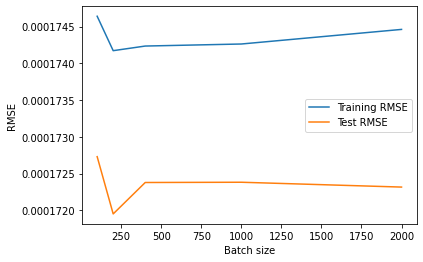

In [ ]:
# Plot the results 
plt.plot(batch_sizes, training_rmse, label="Training RMSE")
plt.plot(batch_sizes, test_rmse, label="Test RMSE")
plt.xlabel("Batch size")
plt.ylabel("RMSE") 
plt.legend()
plt.show()

In [ ]:
print(training_rmse)
print(test_rmse)
print(iters)

[0.00017463986332655316, 0.00017417177368815479, 0.00017423461173396635, 0.00017426238770055862, 0.00017446088116580512]
[0.00017273056281851053, 0.00017195208418669086, 0.0001723792447791745, 0.00017238278019079576, 0.00017231698506895365]
[102, 27, 20, 28, 43]


In [ ]:
iterations = [119*X_train.shape[0]/100, 51*X_train.shape[0]/200,
              18*X_train.shape[0]/400, 22*X_train.shape[0]/1000,
              49*X_train.shape[0]/2000]

print(iterations)

[13090.0, 2805.0, 495.0, 242.0, 269.5]


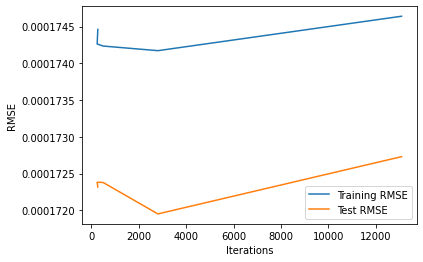

In [ ]:
plt.plot(iterations, training_rmse, label="Training RMSE")
plt.plot(iterations, test_rmse, label="Test RMSE")
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("RMSE")
plt.show()

In [ ]:
W, ii = mini_batch_descent(X_train, y_train, 0.01, 5, 1, 1e-8)
print(ii)

print(W[0])
print(W_an[-1])

5
-3.788707271603544e+57
-0.0008711727272727212


Using SGD does not converge correctly, resulting in RMSE for training and test data that explodes to a very large value and produces numpy overflow errors. It appears that with a batch size >= 250, the solution converges. Larger batch sizes such as 2000 perform fewer weight updates per epoch. 2000 seems to require very few updates to converge, and performs slightly better than a batch size of 1000.

## Part 5 - Learning Rate [2 marks]
Select the best batch size based on fastest convergence (number of times you update the weights) and sweep the learning rate while applying Mini-batch GD. Report your findings on a plot.


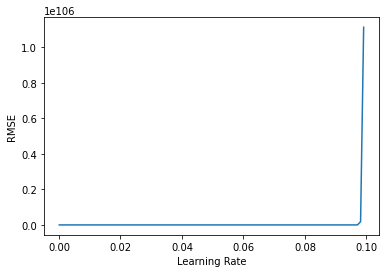

In [ ]:
# Learning rate optimization

learning_rmse = []

for learning_rate in np.arange(0.0001, 0.1, 0.001):

  W, ii = mini_batch_descent(X_train, y_train, learning_rate,
                                              50, 2000, 1e-8)
  
  y_pred = np.dot(X_train, W[1:]) + W[0]
  rmse_value = rmse(y_pred, y_train)
  learning_rmse.append(rmse_value)
 
learning_rates = np.arange(0.0001, 0.1, 0.001)

# Plot the results 
plt.plot(learning_rates, learning_rmse, label="Training RMSE")
plt.xlabel("Learning Rate")
plt.ylabel("RMSE")
plt.show()

The figure suggests that most small learning rates (< 0.1) will work well. Smaller learning rates will converge with greater stability at the expensive of greater number of weight updates. Higher learning rates will converge to the solution faster, but have a greater risk of instability as the weights will jump around much more (noisier descent). At a learning rate of 0.1 or greater, the gradient becomes unstable and the solution diverges resulting in an extremely large RMSE.

## Part 6 - Regularizers [4 marks]



1.   Formula (use a text cell --markdown-- and write in latex): 
  *   Derive the Direct solution formula when a L1 regularizer ($\lambda_1$) is employed.
  *   Derive the Direct solution formula when a L2 regularizer ($\lambda_2$) is employed.
  *   Derive the Gradient Descent weight update formula when the L1 regularizer is employed.
  *   Derive the Gradient Descent weight update formula when the L2 regularizer is employed.



2.   Evaluation:

  *  Apply L1 and L2 regularizers (separately) to the direct solution and plot train and validation error as a function of the $\lambda$. Find the best regularizer ($\lambda$) values to use in the next steps.

    *   Plot mini-batch GD train error and validation error when $\lambda_1$ regularizer is employed. (X-axis: iterations)

    *   Plot mini-batch GD train error and validation error when $\lambda_2$ regularizer is employed. (X-axis: iterations)



* Summarize your findings and explain whether L1 or L2 regularizers are helping the GD convergence. Is it always safe to use a L1 regularizer? How about L2?



**L2 Regularization**

$J(w) = \frac{1}{2N}\sum^{N}_{i=1}(\sum^{k}_{j=1}x_{ij}w_{j} + w_0 - y_i)^{2} + \lambda\sum^{k}_{j=1}(w_{j})^{2}$

We seek to find a $w$ to minimize this cost function. Do do so we must take the derivation of this cost function with respect to W, set the function to 0, and then solve for the analytical solution. We can ignore the constant $\frac{1}{2N} as it just scales the cost.

This function can also be written as...

$J(w) = \frac{1}{2N}(Xw - y)^{T}(Xw - y)+ \lambda w^{T}w$

Expanding...

$J(w) = ((Xw)^{T} - y^{t})(Xw - y) + \lambda w^{T}w$

$J(w) = (Xw)^{T}(Xw) - (Xw)^{T}y - y^{T}(Xw) + y^{T}y + \lambda w^{T}w$

$J(w) = (Xw)^{T}(Xw) - 2y^{T}(Xw) + y^{T}y + \lambda w^{T}w$

Taking the derivative we get

$\frac{dJ(w)}{dw} = X^{T}Xw + X^{T}Xw - 2X^{T}y + \lambda2w$

$\frac{dJ(w)}{dw} = 2X^{T}Xw - 2X^{T}y + \lambda2w$

And so the gradient descent equation would be 

$ w_{i+1} = w_{i} - \alpha(\frac{dJ(w)}{dw})$

Where $\alpha$ is the selected learning rate

or in the case of individual gradients 

$j > 0, \frac{dJ(w_j)}{dw_j} = \frac{1}{N}\sum^{N}_{i=1}(\sum^{k}_{j=1}x_{ij}w_{j} + w_0 - y_i)x_{ij} + \lambda2(w_{j})$

$\frac{dJ(w_0)}{dw_0} = \frac{1}{N}\sum^{N}_{i=1}(\sum^{k}_{j=1}x_{ij}w_{j} + w_0 - y_i)$

Set the derivative equal to 0 to solve for the analytical solution

$2X^{T}Xw - 2X^{T}y + \lambda2w = 0$

$X^{T}Xw - X^{T}y + \lambda w = 0$

$X^TXw +\lambda w = X^{T}y$

$(X^{T}X + \lambda I)w = X^{T}y$

$w = (X^{T}X + \lambda I)^{-1}(X^{T}y)$

**References:** http://www.gatsby.ucl.ac.uk/teaching/courses/sntn/sntn-2017/resources/Matrix_derivatives_cribsheet.pdf

Class notes on linear regression analytical solution

https://towardsdatascience.com/analytical-solution-of-linear-regression-a0e870b038d5





**L1 Regularization**

The work is very similar, and I am reusing a lot of what was derived above.

$J(w) = \frac{1}{2N}\sum^{N}_{i=1}(\sum^{k}_{j=1}x_{ij}w_{j} + w_0 - y_i)^{2} + \lambda\sum^{k}_{j=1}|w_{j}|$

Dropping the same constant and converting to vector form

$J(w) = (Xw - y)^{T}(Xw - y)+ \lambda||w||_{1}$

Simplify in the same manner as above, and take the derivative to get

$\frac{dJ(w)}{dw} = 2X^{T}Xw - 2X^{T}y + \lambda\frac{d||w||_1}{dw}$

Setting equal to 0

$2X^TXw - 2X^{T}y +\lambda\frac{d||w||_1}{dw} = 0$

No direct solution like in the case of L2 regularization...

This is because the L1 norm derivative is not defined. However, we can take subgradients with respect to each weight as the derivative of the absolute value of a variable is defined.

Should have to solve for the gradient of the cost with respect to each weight in the weight vector and use gradient descent...

$ j \neq 0, \frac{dJ(w)}{dw_j} = \frac{2}{2N}\sum^{N}_{i=1}(\sum^{k}_{j=1}x_{ij}w_{j} + w_0 - y_i)x_{ij} + \lambda\frac{d|w_j|}{w_j}  = 0$

$ j = 0, \frac{dJ(w)}{dw_0} = \frac{2}{2N}\sum^{N}_{i=1}(\sum^{k}_{j=1}x_{ij}w_{j} + w_0 - y_i)+ \lambda\frac{d|w_0|}{w_0}  = 0$

where $\frac{d|w_j|}{dw_j} = 1$ if $w_j > 0$ or $-1$ if $w_j < 0$

Can multiply by N to simply these equations further, and this is really just our standard gradient descent with an additional tunable parameter to shrink large weights.





In [ ]:
# Analytical solution with L2 regularization

y_train_errors = []
y_test_errors = []

for L2_const in np.arange(0.01, 5, 0.01):
  
  W_an_L2 = np.dot(np.linalg.inv(np.dot(X_train_an.T, X_train_an) + L2_const*np.identity(41)),
              np.dot(X_train_an.T, y_train))
  
  y_pred_train = np.dot(X_train_an, W_an_L2)
  train_error = rmse(y_pred_train, y_train)
  y_train_errors.append(train_error)
  
  y_pred_test = np.dot(X_test_an, W_an_L2)
  test_error = rmse(y_pred_test, y_test)
  y_test_errors.append(test_error)

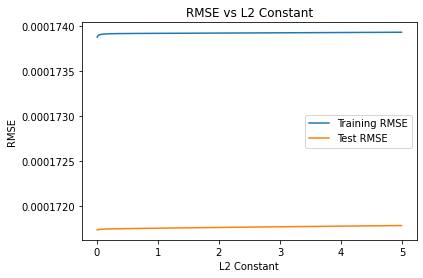

In [ ]:
plt.plot(list(np.arange(0.01, 5, 0.01)), y_train_errors, label = "Training RMSE")
plt.plot(list(np.arange(0.01, 5, 0.01)), y_test_errors, label = "Test RMSE")
plt.legend()
plt.xlabel("L2 Constant")
plt.ylabel("RMSE")
plt.title("RMSE vs L2 Constant")
plt.show()

In [ ]:
# L2 Regularization Gradient Descent 

def L2_update_weights(X, error, W, learning_rate, L2_const):

  # Ask about dropping the 2 
  loss_1 = -2*(learning_rate/X.shape[0])*(np.dot(error, X)) + (2*L2_const)*W[1:]
  loss_2 = -2*learning_rate*error.sum()/X.shape[0]
  W[1:] = W[1:] - loss_1
  W[0] = W[0] - loss_2
  return W

def L2_mini_batch_descent(X_train, y_train, learning_rate, n_iter, batch_size, tol,
                          L2_const):

  W = np.zeros(41)
  rmse_value = 0
  rmse_old = 0

  for ii in range(n_iter+1):
    X_train, y_train = shuffle(X_train, y_train)

    for i in range(0, X_train.shape[0], batch_size):
      
      X_train, y_trian = shuffle(X_train, y_train)

      rmse_old = copy.deepcopy(rmse_value)
      X_batch = X_train[i:i + batch_size]
      y_batch = y_train[i:i + batch_size]
      y_pred = calculate_values(W, X_batch)
      error = calculate_error(y_pred, y_batch)
      W = L2_update_weights(X_batch, error, W, learning_rate, 0.1)
      rmse_value = rmse(y_pred, y_batch)

    if abs(rmse_value - rmse_old) <= tol:
       break
    else:
      continue

  return W, ii 
  

In [ ]:
# For timing function speed
import time

start_time = time.time()
W, ii = L2_mini_batch_descent(X_train, y_train, 0.01, 1000, 2000, 1e-8, 0.001)
y_pred_L2 = np.dot(X_train, W[1:]) + W[0]
rmse_200_epochs_L2 = rmse(y_pred_L2, y_train)
print(rmse_200_epochs_L2)
print(time.time() - start_time)
print(ii)


start_time = time.time()
W, ii = mini_batch_descent(X_train, y_train, 0.01, 1000, 2000, 1e-8)
y_pred_train = np.dot(X_train, W[1:]) + W[0]
error_for_comparison = rmse(y_pred_train, y_train)
print(error_for_comparison)
print(time.time() - start_time)
print(ii)


0.00041031172606443813
12.731532335281372
595
0.00017431553500767906
0.36060547828674316
48


The L2 regularized model does not reach an RMSE as close to the analytical RMSE when compared to the unregularized model. This makes sense as the function of L2 regularization is to prevent overfitting. Whichever direction the unregularized gradient wants to "push" a weight $w_j$, the L2 regularization "pushes" in the opposite direction. So if the standard gradient says to increased $w_j$ the L2 regularization term will decrease the amount by which $w_j$ is increased. Really L2 regularization is just applying a constraint to our weights, and the gradient becomes a Lagrangian optimization. The unregularized model also converges faster, which makes sense as the regularization term reduces the aggressiveness of the descent.

In [ ]:
# L1 Regularization Gradient Descent 

def L1_update_weights(X, error, W, learning_rate, L1_const):

  signs = [L1_const if weight >= 0 else -L1_const for weight in W[1:]]
  # Ask about dropping the 2 
  #print(L1_const*signs)
  loss_1 = -2*(learning_rate/X.shape[0])*(np.dot(error, X)) + signs
  loss_2 = -2*learning_rate*error.sum()/X.shape[0]
  W[1:] = W[1:] - loss_1
  W[0] = W[0] - loss_2
  return W

def L1_mini_batch_descent(X_train, y_train, learning_rate, n_iter, batch_size, tol,
                          L1_const):

  W = np.zeros(41)
  rmse_value = 0
  rmse_old = 0

  for ii in range(n_iter+1):
    X_train, y_train = shuffle(X_train, y_train)

    for i in range(0, X_train.shape[0], batch_size):
      
      X_train, y_trian = shuffle(X_train, y_train)

      rmse_old = copy.deepcopy(rmse_value)
      X_batch = X_train[i:i + batch_size]
      y_batch = y_train[i:i + batch_size]
      y_pred = calculate_values(W, X_batch)
      error = calculate_error(y_pred, y_batch)
      W = L1_update_weights(X_batch, error, W, learning_rate, L1_const)
      rmse_value = rmse(y_pred, y_batch)

    if abs(rmse_value - rmse_old) <= tol:
       break
    else:
      continue

  return W, ii

In [ ]:
# L1 regularization constant

training_errors = []
test_errors = []

for L1_const in np.arange(0.01, 0.5, 0.05):

  W, ii = L1_mini_batch_descent(X_train, y_train, 0.01, 1000, 2000, 1e-8, 
                                L1_const)

  # Training and Test RMSE 
  y_pred_train = np.dot(X_train, W[1:]) + W[0]
  training_error = rmse(y_pred_train, y_train)
  training_errors.append(training_error)

  y_pred_test = np.dot(X_test, W[1:]) + W[0]
  test_error = rmse(y_pred_test, y_test)
  test_errors.append(test_error)

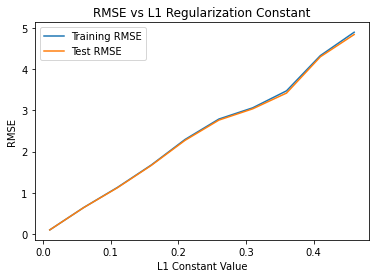

In [ ]:
x_range = list(np.arange(0.01, 0.5, 0.05))

plt.plot(x_range, training_errors, label = "Training RMSE")
plt.plot(x_range, test_errors, label = "Test RMSE")
plt.xlabel("L1 Constant Value")
plt.ylabel("RMSE")
plt.legend()
plt.title("RMSE vs L1 Regularization Constant")
plt.show()

In [ ]:
import time
start_time = time.time()
W, ii = L1_mini_batch_descent(X_train, y_train, 0.01, 1000, 2000, 1e-8, 0.001)
y_pred_L1 = np.dot(X_train, W[1:]) + W[0]
rmse_200_epochs_L1 = rmse(y_pred_L1, y_train)
print(rmse_200_epochs_L1)
print(time.time() - start_time)
print(ii)

start_time = time.time()
W, ii = mini_batch_descent(X_train, y_train, 0.01, 1000, 2000, 1e-8)
y_pred_train = np.dot(X_train, W[1:]) + W[0]
error_for_comparison = rmse(y_pred_train, y_train)
print(error_for_comparison)
print(time.time() - start_time)
print(ii)

0.011246928481367099
24.171682596206665
1000
0.00017434839681185088
0.32031798362731934
47


Since L1 regularization shrinks model weights towards 0 to reduce overfitting, it is appropriate for situations in which there are a large number of model parameters and a small amount of data. L1 regularization can be seen as a type of feature selection. L2 regularization shrinks weights less aggressively. We can see above that L1, even with a small constant, aggressively increases the RMSE, and makes convergence take many more iterations in comparison to the unregulated model.

## Part 7 - Introducing Momentum [4 marks]

Momentum is a popular technique that helps the gradient descent algorithm to converge faster. Simply, it behaves like a moving average of gradients. First, take a look at [here](https://towardsdatascience.com/stochastic-gradient-descent-with-momentum-a84097641a5d) to get familiar with the concept.

To summarize, If the weight update formula in the time-step $t$ is $w_t = w_{t-1} - \alpha~g_t$, the $g_t$ using momentum could be computed as $g_t = \beta~g_{t-1} + (1-\beta) \frac{{\partial J}}{\partial w}$. $\beta$ is the momentum coefficient, between [0, 1]. Weight updates ($g_t$) with momentum are not only computed based on the derivative of the loss function but also is a function of previous weight updates.

If you put $\beta=0$ in the $g_t$ equation, it would be the original gradient descent method. 

Train a linear model with a regularizer and various values of momentums. Plot your training and validation error for each iteration. Comment on the effect of momentum.

In [ ]:
def update_weights_momentum(X, error, W, learning_rate, beta,
                            gradient_1, gradient_2):

  # Ask about dropping the 2 
  loss_1 = -2*(learning_rate/X.shape[0])*(np.dot(error, X))
  #loss_1 = -1*(learning_rate)*(np.dot(error, X))
  loss_2 = -2*learning_rate*error.sum()/X.shape[0]
  #loss_2 = -1*(learning_rate)*error.sum()
  gradient_1 = (1 - beta)*loss_1 + beta*learning_rate*gradient_1
  gradient_2 = (1 - beta)*loss_2 + beta*learning_rate*gradient_2
  #gradient_2 = 0
  
  W[1:] = W[1:] - gradient_1
  W[0] = W[0] - gradient_2

  return W, gradient_1, gradient_2

def mini_batch_descent_momentum(X_train, y_train, X_test, y_test,
                                learning_rate, n_iter, batch_size, tol, beta):

  W = np.zeros(41)
  rmse_value = 0
  rmse_old = 0
  gradient_1 = np.zeros(40)
  gradient_2 = 0
  train_rmse_values = []
  test_rmse_values = []

  for ii in range(n_iter+1):
    
    X_train, y_train = shuffle(X_train, y_train)
    y_train_pred = np.dot(X_train, W[1:]) + W[0]
    train_rmse_value = rmse(y_train_pred, y_train)
    train_rmse_values.append(train_rmse_value)

    y_test_pred = np.dot(X_test, W[1:]) + W[0]
    test_rmse_value = rmse(y_test_pred, y_test)
    test_rmse_values.append(test_rmse_value)

    for i in range(0, X_train.shape[0], batch_size):

      rmse_old = copy.deepcopy(rmse_value)
      X_batch = X_train[i:i + batch_size]
      y_batch = y_train[i:i + batch_size]
      y_pred = calculate_values(W, X_batch)
      error = calculate_error(y_pred, y_batch)
      W, gradient_1, gradient_2 = update_weights_momentum(X_batch, error, W, 
                                                          learning_rate, beta,
                                                          gradient_1, 
                                                          gradient_2)
      
      rmse_value = rmse(y_pred, y_batch)


    if abs(rmse_value - rmse_old) <= tol:
       break
    else:
      continue

  return W, ii, train_rmse_values, test_rmse_values

In [ ]:
W, ii, train_rmse_values, test_rmse_values = mini_batch_descent_momentum(X_train, 
                                                                         y_train, 
                                                                         X_test, 
                                                                         y_test, 
                                                                         0.01, 
                                                                         1000, 
                                                                         2000, 
                                                                         1e-8, 
                                                                         0.5)

W, ii_2, train_rmse_values_2, test_rmse_values_2 = mini_batch_descent_momentum(X_train, 
                                                                             y_train, 
                                                                             X_test, 
                                                                             y_test, 
                                                                             0.01, 
                                                                             1000, 
                                                                             2000, 
                                                                             1e-8, 
                                                                             0.2)

W, ii_3, train_rmse_values_3, test_rmse_values_3 = mini_batch_descent_momentum(X_train, 
                                                                             y_train, 
                                                                             X_test, 
                                                                             y_test, 
                                                                             0.01, 
                                                                             1000, 
                                                                             2000, 
                                                                             1e-8, 
                                                                             0.9)

W, ii_4, train_rmse_values_4, test_rmse_values_4 = mini_batch_descent_momentum(X_train, 
                                                                             y_train, 
                                                                             X_test, 
                                                                             y_test, 
                                                                             0.01, 
                                                                             1000, 
                                                                             2000, 
                                                                             1e-8, 
                                                                             0.0)

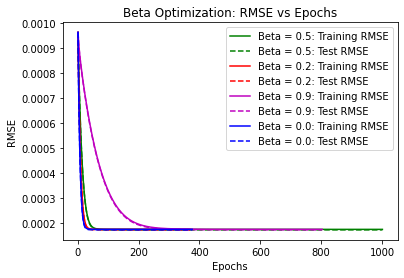

In [ ]:
plot_range = list(range(1, ii+2))
plot_range_2 = list(range(1, ii_2+2))
plot_range_3 = list(range(1, ii_3+2))
plot_range_4 = list(range(1, ii_4+2))

plt.plot(plot_range, train_rmse_values, "g", label="Beta = 0.5: Training RMSE")
plt.plot(plot_range, test_rmse_values, "g--", label="Beta = 0.5: Test RMSE")
plt.plot(plot_range_2, train_rmse_values_2, "r", label="Beta = 0.2: Training RMSE")
plt.plot(plot_range_2, test_rmse_values_2, "r--", label="Beta = 0.2: Test RMSE")
plt.plot(plot_range_3, train_rmse_values_3, "m", label="Beta = 0.9: Training RMSE")
plt.plot(plot_range_3, test_rmse_values_3, "m--", label="Beta = 0.9: Test RMSE")
plt.plot(plot_range_4, train_rmse_values_4, "b", label="Beta = 0.0: Training RMSE")
plt.plot(plot_range_4, test_rmse_values_4, "b--", label="Beta = 0.0: Test RMSE")
plt.title("Beta Optimization: RMSE vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()
plt.show()

Above I programmed an implementation of momentum and plotted various values of the $\beta$ constant. In theory momentum adds "acceleration" to gradient descent. It adds a fraction of the previous gradient value to the current gradient value. If the gradients are all, for example, positive then the gradient descent will increase the gradients to a greater degree. In this data set I found that momentum did not accelerate the solution convergence. This is likely because the data set is relatively straightforward, and the momentum is causing the weights to overshoot.

## Part 8 - Find a dataset online [3 marks]


Find a dataset online and train a linear model with the techniques you learned to make a prediction. 

*   Introduce your dataset,
*   How did you train your model,
*   Show your results.

Hint: you can find various datasets in here: https://www.kaggle.com/datasets.

To use a dataset in Colab, you can upload it in your Google drive and access it in Colab ([help here](https://medium.com/analytics-vidhya/how-to-fetch-kaggle-datasets-into-google-colab-ea682569851a)), or you can download the dataset on your local machine and upload it directly to Colab using the following script.

```
from google.colab import files
uploaded = files.upload()
```

When submitting your project on Quercus, Please make sure you are also uploading your dataset so we can fully run your notebook.






**Dataset Introduction:**

This dataset is from the textbook "Machine Learning with R" by Brett Lantz. I randomly selected it from Kaggle after searching for datasets appropriate for linear regression analysis. The dataset involves using several features (some of which are categorical) to predict the insurance cost for an individual. 

**Dataset Modeling:**

I used sklearn's built in Ridge regression function with cross-validation to select an optimal $\lambda_{2}$ and then fit the data. 

The data results including data preprocessing are below.

In [ ]:
# Medical Cost Personal Database 
# Link: https://www.kaggle.com/mirichoi0218/insurance/data

# Deprecated, you can upload the file via the sidebar
# from google.colab import files
# uploaded = files.upload()
import pandas as pd
import numpy as np

insurance_df = pd.read_csv('insurance.csv')

insurance_df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [ ]:
# Data preprocessing 

insurance_df = pd.get_dummies(insurance_df)

# Put the columns back in order 
charges = insurance_df.pop("charges")
insurance_df.insert(11, charges.name, charges)

In [ ]:
# Split and scale the data 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Get the X data and the y data from the df

X = insurance_df.iloc[:,:-1].values
y = insurance_df.iloc[:,-1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=41,
                                                    test_size=0.3)

sc = StandardScaler()

sc.fit(X_train)

X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Perform the linear regression with L2 regularization, doing a search
# to optimize the L2 constant

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(cv=10)

#param_grid = {"alpha": np.arange(0.001, 0.5, 0.001)}
#gscv = GridSearchCV(ridge, param_grid, cv=10)
ridge.fit(X_train, y_train)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=10, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

In [ ]:
from sklearn.metrics import mean_squared_error

print(ridge.score(X_train, y_train))
print(ridge.score(X_test, y_test))

0.7667478222446934
0.6946238628300248


Here I implemented a ridge regression with sklearn's built in ridge regression function which implements cross-validation. The $R^2$ value for the training set is 0.7667478222446934 and the $R^2$ for the test set is 0.6946238628300248 indicating a relatively strong fit. 